In [69]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mean
import numpy as np
import itertools
from itertools import permutations
import my_functions as myf
import operator

# 1. ***Data***

## **Data Preprocessing**

As always, in the data science area, you can find some inconsistencies in the provided data. Therefore, some modifications should be made to the data to make it consistent across all of the datasets you have. To ensure consistency in the data, keep the following in mind:

  1)  Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
        - Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
        - Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
        - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length    limit in 'hero-network.csv'.


  2)  Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.


In [2]:
hero_df = pd.read_csv('hero-network.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df = pd.read_csv('nodes.csv')

We decided to homogenize all the DFs since there are many words that are the same but with extra characters in the end
and in the hero-network's DF there is a character limit of 20 digits.

We report here some examples of the issues we could find

In [3]:
print('SPIDER-MAN/PETER PAR' in hero_df.values)         #digits limit
print('SPIDER-MAN/PETER PARKERKER' in nodes_df.values)  #with an extra "KER" in the end
print('SPIDER-MAN/PETER PARKER' in edges_df.values)     

True
True
True


Trimming to the 20th character and removing final blank spaces or final "/" character

In [4]:

hero_df['hero1'] = hero_df['hero1'].apply(lambda x: x.rstrip('/ ')[:20])
hero_df['hero2'] = hero_df['hero2'].apply(lambda x: x.rstrip('/ ')[:20])
edges_df['hero'] = edges_df['hero'].apply(lambda x: x.rstrip('/ ')[:20])
edges_df['comic'] = edges_df['comic'].apply(lambda x: x.rstrip('/ ')[:20])
nodes_df['node'] = nodes_df['node'].apply(lambda x: x.rstrip('/ ')[:20])


Let's check if the are any anomalies in our data now that we have formatted them.

In [5]:
print('SPIDER-MAN/PETER PAR' in hero_df.values)         #digits limit
print('SPIDER-MAN/PETER PARKERKER' in nodes_df.values)  #with an extra "KER" in the end
print('SPIDER-MAN/PETER PARKER' in edges_df.values)

True
False
False


Now let's remove the rows from the hero_df which has the same hero in both columns.

In [6]:
hero_df.drop(hero_df[hero_df['hero1'] == hero_df['hero2']].index, inplace = True)

## **Graphs setup**

First graph: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

We group by the hero1 and hero2 on the hero_df to obtain the number of occurencies between to nodes, which corresponds to the number of times a hero collaborated with another hero. The we obtain a new dataset from this operation, in fact we need the 'weight' variable in our dataset.

In [7]:
count_hero_df = hero_df.groupby(["hero1", "hero2"]).size().reset_index(name='weight')

We set the weight to be 1/n because it has to be inversely related to the number of times each hero collaborted with another hero. In this way heroes who got lot of collaborations will be penalized.

In [8]:
count_hero_df['weight'] = count_hero_df['weight'].apply(lambda x: 1/x)

In [9]:
count_hero_df

,hero1,hero2,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1.0
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1.0
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1.0
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1.0
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1.0
...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1.0
224095,ZZZAX,"ROSS, GEN. THADDEUS",0.5
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1.0
224097,ZZZAX,TIGRA/GREER NELSON,1.0


Now we can create a 'weighted graph' using the weight we calculated as our edge attribute.

In [10]:
G_hero_net = nx.from_pandas_edgelist(count_hero_df, 'hero1', 'hero2', edge_attr='weight', create_using=nx.MultiGraph)

In [11]:
G_hero_net['ZZZAX']['RODRIGUEZ, DEBRA']

AtlasView({0: {'weight': 1.0}})

**Second graph** : The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

We need to set the 'node' column as index of the nodes_df dataframe in order to proceed with our request.


In [12]:
print(len(nodes_df))
print(len(nodes_df.node.unique()))

19090
19087


We see that there are only 3 non unique values in the 'node' column se we decided to drop them to mantain the dataframe consistency.

In [13]:
nodes_df = nodes_df.drop_duplicates(subset=['node'])

We transform the node column in the new index of the dataframe and we transform it in a dictionary.

In [14]:
nodes_attr = nodes_df.set_index('node').to_dict(orient = 'index')

Now we can proceed with the creation of the second graph. First we create a new graph starting from the edges dataframe and then we select the nodes_attr dictionary to be the attributes of our nodes.

In [15]:
G_edges_net = nx.from_pandas_edgelist(edges_df, 'hero', 'comic')
nx.set_node_attributes(G_edges_net, nodes_attr)

In [16]:
G_edges_net.nodes['VENUS II']

{'type': 'hero'}

# 2. ***Backend Implementation***

## ***Functionality 1 - Extract the graph's features***

In [18]:
def Functionality_1(graph,graph_type,N=6421): 
    if (N!=6421 and graph_type==1):
        graph = myf.TOP_N(N,G_hero_net,edges_df)
    num_nodes = myf.number_of_nodes(graph_type,graph)
    if graph_type == 2:    
        num_comics = myf.number_of_nodes(graph_type,graph)[0]
        num_hero = myf.number_of_nodes(graph_type,graph)[1]
    num_collabs_dict = myf.number_of_collaborations_dict(graph_type,graph)
    num_hero_comic_dict = myf.number_of_hero_in_each_comic_dict(graph_type)
    dens = myf.graph_density(graph)
    d_distr = myf.degree_distribution(graph)
    avg_degree = myf.degree_mean(graph)
    hubs = myf.nodes_hubs(graph)
    if dens>=0.5:
        density = "dense"
    else:
        density = "sparse"
    if graph_type == 2:
        return [num_comics, num_hero], num_hero_comic_dict, dens, d_distr, avg_degree, hubs, density
    return num_nodes, num_collabs_dict, num_hero_comic_dict, dens, d_distr, avg_degree, hubs, density

In [19]:
num_nodes, num_collabs_dict, num_hero_comic_dict, dens, d_distr, avg_degree, hubs, density = Functionality_1(G_hero_net, 1, N=6421)

In [20]:
num_com_hero, num_hero_comic_dict2, dens2, d_distr2, avg_degree2, hubs2, density2 = Functionality_1(G_edges_net, 2, N=6421)

## ***Visualization 1 - Visualize some features of the network***


In [22]:
myf.Viz1_graph_info(num_nodes, dens, avg_degree, density, 1)

,Number of nodes,Density,Avg Degree,Sparse or Dense
0,6421,0.010873,69.8019,sparse


In [23]:
myf.Viz1_graph_info(num_com_hero, dens2, avg_degree2, density2, 2)

,Number of comic nodes,Number of hero nodes,Density,Avg Degree,Sparse or Dense
0,12651,6436,0.000528,10.0701,sparse


This function returns a table listing all the network hubs, which are identified as vertices with a high degree, meaning it is connected to many other vertices.

In our case hubs are identified as nodes having degrees more extensive than the 95th percentile of the degree distribution.


In [25]:
myf.Viz1_hubs(hubs)

,Hubs
0,ANGEL/WARREN KENNETH
1,ANT-MAN II/SCOTT HAR
2,AURORA/JEANNE-MARIE
3,BLACK PANTHER/T'CHAL
4,BLACK WIDOW/NATASHA
...,...
313,"DE LA FONTAINE, CONT"
314,MAGMA/AMARA AQUILLA
315,"JAMESON, MARLA MADIS"
316,"WATSON, ANNA"


In [26]:
myf.Viz1_hubs(hubs2)

,Hubs
0,COC 1
1,Q 14
2,ABOMINATION/EMIL BLO
3,H2 278
4,SWII 7
...,...
922,ZABU
923,ZARAN/MAXIMILLIAN ZA
924,"ZARRKO, ARTHUR"
925,ZEUS


- A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)

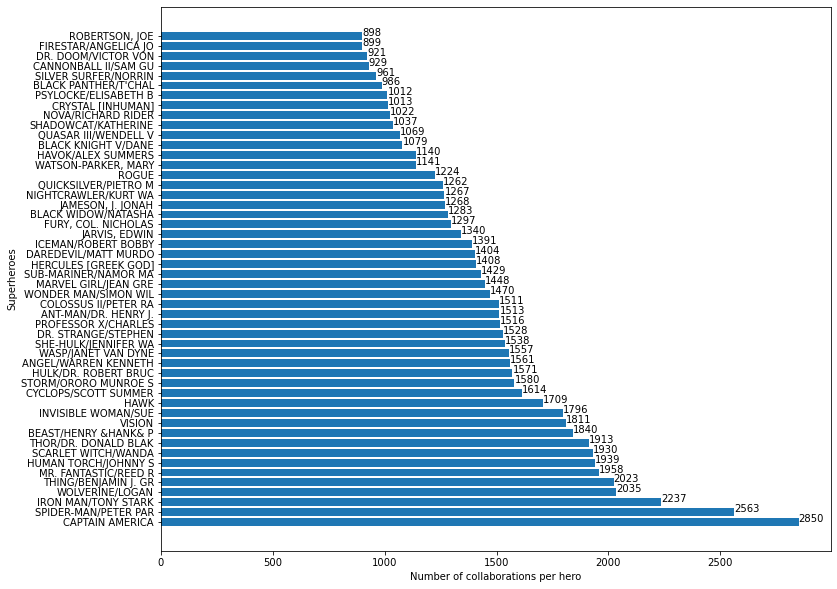

In [27]:
converted_dict = dict( sorted(num_collabs_dict.items(), key=operator.itemgetter(1),reverse=True))
heroes = list(converted_dict.keys())[:50]
n_colabs = list(converted_dict.values())[:50]
fig = plt.figure(figsize=(12, 10))
bars = plt.barh(heroes,n_colabs)

for  bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    plt.text(width, label_y, s=f'{width}')
plt.xlabel("Number of collaborations per hero")
plt.ylabel("Superheroes")
plt.show()

- A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

Text(0, 0.5, 'Comics')

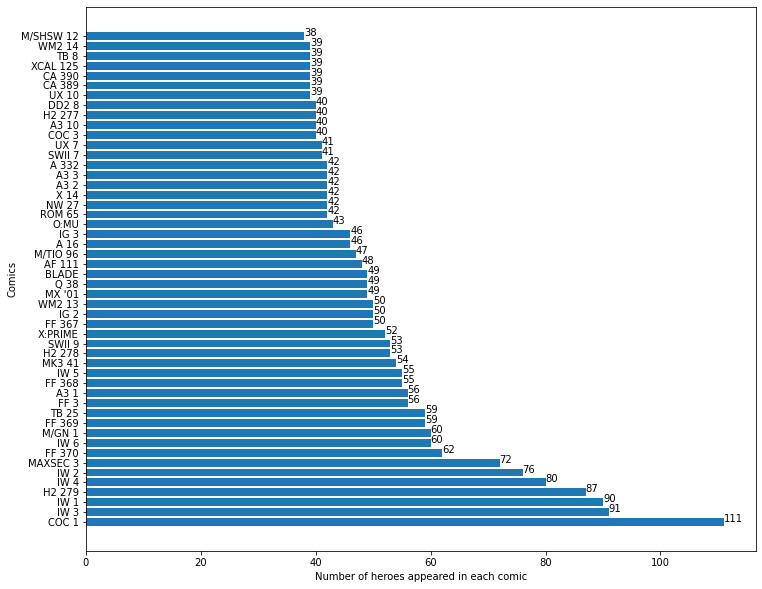

In [28]:
converted_dict = dict( sorted(num_hero_comic_dict2.items(), key=operator.itemgetter(1),reverse=True))
comics = list(converted_dict.keys())[:50]
n_heroes = list(converted_dict.values())[:50]
fig = plt.figure(figsize=(12, 10))
bars = plt.barh(comics,n_heroes)

for  bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    plt.text(width, label_y, s=f'{width}')
plt.xlabel("Number of heroes appeared in each comic")
plt.ylabel("Comics")

- A plot depicting the degree distribution of the network

- Note: You can do the plot on a limited number of heroes/comic books to have a better visualization for the charts that ask for some insights about all of the comics/heroes (e.g. for the first 50)

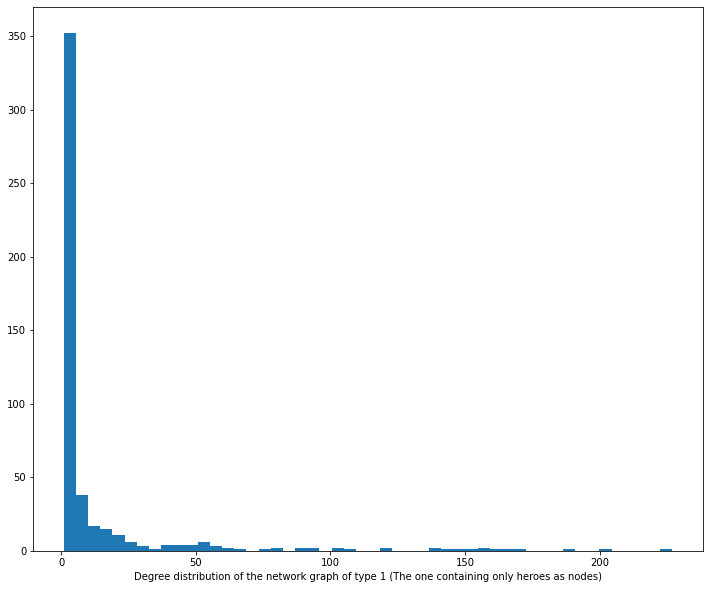

In [29]:
values = list(d_distr.values())

fig = plt.figure(figsize=(12, 10))
plt.hist(values, bins = 50)
plt.xlabel("Degree distribution of the network graph of type 1 (The one containing only heroes as nodes)")
plt.show()

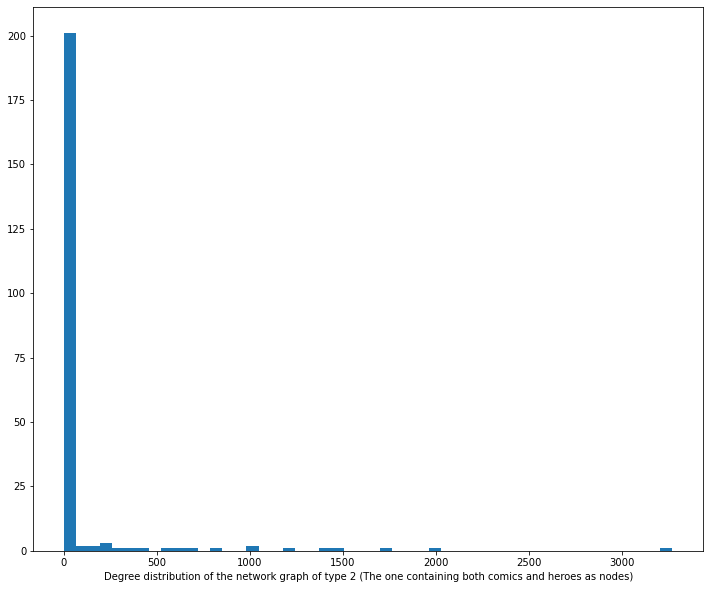

In [30]:
values = list(d_distr2.values())

fig = plt.figure(figsize=(12, 10))
plt.hist(values, bins = 50)
plt.xlabel("Degree distribution of the network graph of type 2 (The one containing both comics and heroes as nodes)")
plt.show()

## ***Functionality 2 - Find top superheroes!***

###  Metrics

* **Degree centrality**:

   The degree centrality of a node in a graph is a measure of the importance of that node in the graph. It is defined as the number of edges incident to the node, i.e., the number of neighbors it has. In other words, it is the number of connections a node has in the graph. The degree centrality of a node can be calculated as:
   
   $ Degree\,Centrality = \frac{number\,\,of\,\,neighbors}{number\,of\,nodes\, -\, 1} $

   Nodes with high degree centrality are often considered important or influential in the graph, as they have a large number of connections and may be able to spread information or influence other nodes more effectively.


* **Betweenness centrality**:

   The betweenness centrality of a node in a graph is a measure of the importance of that node in terms of the number of shortest paths that pass through it. It is defined as the fraction of all shortest paths in the graph that pass through the node. In other words, it is a measure of the node's centrality in terms of the connectivity of the graph.
   The betweenness centrality of a node can be calculated as:

   $ Betweenness\,centrality = \frac{num\,of\,shortest\,path\,passing\,through\,the\,node}{total\,num\,of\,shortest\,paths\,in\,the\,graph}$
   
   Nodes with high betweenness centrality are often considered important or influential in the graph, as they are more likely to be on the shortest path between other nodes and may be able to control the flow of information or influence other nodes more effectively.

* **Closeness centrality** :

    The closeness centrality of a node in the graph is a measure of the importance of that node in terms of its ability to reach other nodes in the graph. It is defined as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph. In other words, it is a measure of the node's centrality in terms of its proximity to other nodes.The closeness centrality can be calculated as:

    $ Closeness\,centrality = \frac{1}{sum\,of\,the\,shortest\,path\,distances\,from\,the\,node\,to\,all\,other\,nodes}$ 

    Nodes with high closeness centrality are often considered important or influential in the graph, as they are able to reach other nodes quickly and may be able to spread information or influence other nodes more effectively.

* **Page rank**:

    The page rank algorithm is a way to measuring the importance or ranking of nodes in a network. In the context of a network, the PageRank of a node is a measure of the importance of that node based on the number and quality of the edges pointing to it. Nodes with a higher PageRank are considered more important and are more likely to appear at the top of search results.
    
    To calculate the PageRank of the nodes in a network, the algorithm follows these steps:
    * First of all we need to transform our graph in a directed graph.
    * We need to assign a initial PageRank score to each node.
    * Then we need to iteratively update the PageRank score of each node based on the PageRank score of the nodes that link to it. Specifically, the PageRank of a node is equal to the sum of the PageRanks of the nodes that link to it, divided by the number of outbound links from each of those nodes.
    We also need to use a damping factor in order to avoid infinite loops and allow the algorithm to converge.
    * We need to repeat the previous step until the score converge.

### Correlation between different metrics

The correlation between different network metrics will depend on the specific characteristics of the network and the definition of the metrics. In general, different metrics may capture different aspects of the network and may not be strongly correlated.

For example, **degree centrality** measures the number of connections a node has, while **betweenness centrality** measures the number of times a node acts as a "bridge" between other nodes in the network. These two metrics may not be strongly correlated, as they capture different aspects of the network.

In the same way, also the **closeness centrality** capture another different aspect of the network, in fact this metric is a measure of the average distance of a node to all other nodes in the network. High closeness centrality indicates a node that is considered to be central to our network.

Similarly, **PageRank**, which is a measure of the importance or ranking of a node based on the number and quality of the links pointing to it, may not be strongly correlated with other metrics such as degree centrality or betweenness centrality.

In [32]:
def functionality_2(graph, node, metric, N=6421): 
    
    if N!=6421:
        graph = myf.TOP_N(N,G_hero_net,edges_df)
    
    if metric.lower()=='betweeness':
        btw_g = myf.betweeness_metric(graph)
        btw_n = myf.betweeness_metric(graph)[node]
        graph_output = myf.betweeness_metric(graph)
        node_output = myf.betweeness_metric(graph)[node]
    elif metric.lower()=='pagerank':
        graph_output = myf.page_rank_metric(graph)
        node_output = myf.page_rank_metric(graph)[node]
    elif metric.lower()=='closenesscentrality':
        graph_output = myf.closeness_metric(graph)
        node_output = myf.closeness_metric(graph)[node]
    elif metric.lower()=='degreecentrality':
        graph_output = myf.degree_metric(graph)
        node_output = myf.degree_metric(graph)[node]
    else:
        print('This metric is not included')
    return metric, graph_output, node_output
   

In [33]:
metric, graph_output, node_output = functionality_2(G_hero_net, 'SCARLET WITCH/WANDA', 'pagerank', 45)

## ***Visualization 2  - Visualize centrality measure***
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

A table containing the information related to the requested centrality measure for:
- The average of the requested centrality measure for all of the network's nodes
- The requested centrality measure's value for the given node

In [37]:
myf.Vis2_table_maker(metric, graph_output, node_output)

,Requested centrality measure,All nodes in network (avg),Given node
0,pagerank,0.998173,1.012989


## ***Functionality 3 - Shortest ordered Route***

In [39]:
start = ['HAWK']
sequence = ['PEATOR', 'SPIDER-MAN/PETER PAR', 'SHAPE', 'BI-BEAST II','TANA NILE']
end = ['RAMBO']

This function takes as input the starting node, the ordered sequence of nodes to be visited and the ending node. The aim of this function is to find the shortest path between the start node and the final node such that all the nodes contained in the sequence are visited in the requested order.

The method used to build this function is the following:
* Find the shortest path between the start node and the first node in the sequence.
* Find the shortest path between the first node and the second node in the sequence.
* Follow the same approach until the final node.

The resulting shortest path is the concatenation of the shortest paths between all the nodes.


In [40]:
def functionality_3(G_hero_net, sequence, start, end ):
    
    complete_list = start + sequence + end
    complete_path = list()
    for i in range(len(complete_list)-1):
        path = nx.shortest_path(G_edges_net, source=complete_list[i], target=complete_list[i+1])
        complete_path.append(path[0:len(path)-1])
        i += 1
    complete_path= list(itertools.chain(*complete_path)) + end
    
    return(complete_path)
    

## ***Visualization 3 - Visualize the shortest-ordered route***

In [41]:
complete_path = functionality_3(G_hero_net, sequence, start, end )

In [42]:
print("The shortest path from " + start[0] + " to "+ end[0]+ " is:")
print(complete_path)

The shortest path from HAWK to RAMBO is:
['HAWK', 'COC 1', 'PEATOR', 'ASM 223', 'SPIDER-MAN/PETER PAR', 'Q 23', 'ARCANNA/ARCANNA JONE', 'A3 5', 'SHAPE', 'Q 14', 'BI-BEAST II', 'T 315', 'IRON MAN/TONY STARK', 'A 105', 'TANA NILE', 'A 105', 'AMPHIBIUS', 'M/FAN 1', 'SPIDER-MAN/PETER PAR', 'SLEEP 17', 'RAMBO']


In [43]:
#def shortest_order_route(path_list)
index_edges_df = edges_df.assign(row_number=range(len(edges_df)))

In [44]:
#Create dataframe with comics and heroes present in the "complete_path" list and their neighbors for rappresentation. 
subset_and = edges_df[edges_df.hero.isin(complete_path) & edges_df.comic.isin(complete_path)]
subset_or = edges_df[edges_df.hero.isin(complete_path) | edges_df.comic.isin(complete_path)]
subset_or_25 = subset_or.sample(n=25)
#subset_or_25 = subset_or.head(25)
frames = [subset_and, subset_or_25]
result = pd.concat(frames)
subset = result.drop_duplicates()

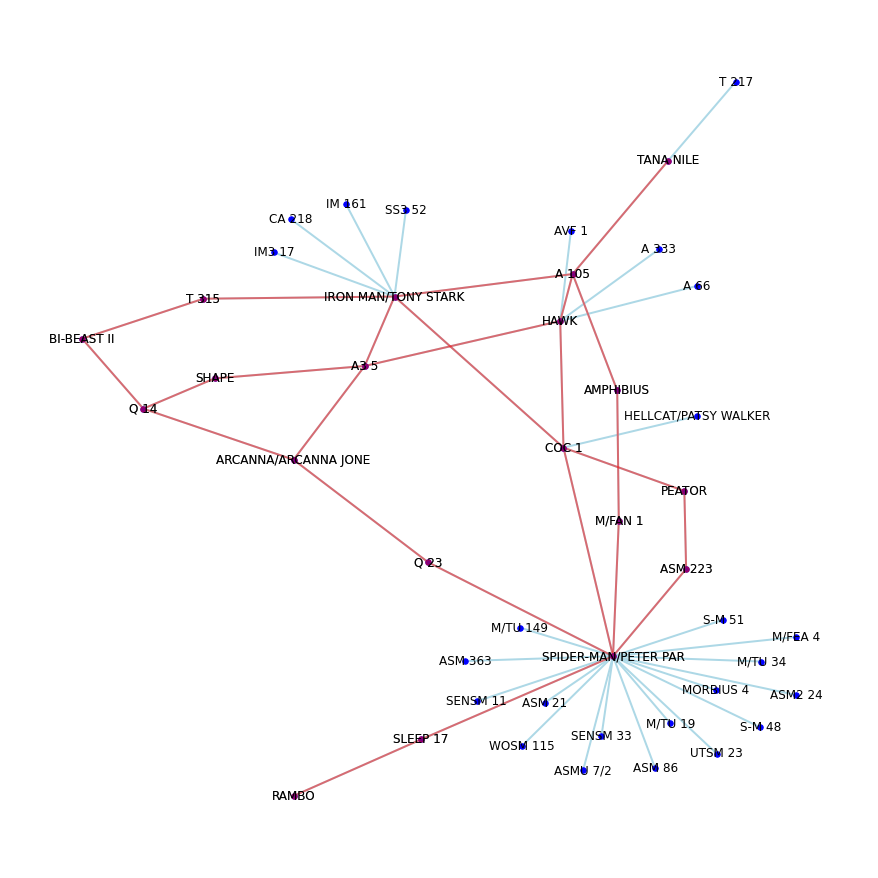

In [45]:
G = nx.from_pandas_edgelist(subset, "hero", "comic")
H = nx.subgraph(G, complete_path)
# Disegna il grafo
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=True, font_size = 12, node_size = 30, node_color='blue', edge_color='lightblue', width= 2)
# Disegna il sottografo in rosso
nx.draw(H, pos, with_labels=True, font_size = 12, node_size = 30, node_color='red', edge_color='red', alpha=0.5, width= 2)

## ***Functionality 4 - Disconnecting Graphs***

In [47]:
def functionality_4(graph_data, n, heroA = 'CAPTAIN AMERICA', heroB = 'IRON MAN/TONY STARK'):
    small_graph_f4 = G_hero_net.subgraph(list(G_hero_net.nodes())[:n])
    vals = myf.min_cut(small_graph_f4,heroA, heroB)
    return(vals)

In [48]:
vals = functionality_4(G_hero_net, n = 200, heroA = 'FROST, CARMILLA', heroB = 'DRACULA | MUTANT X-V')

## ***Visualization 4 - Visualize the disconnected graph***

In [49]:
print("The minimum number of links required to disconnect the original graph in two disconnected subgraphs is :", len(vals))

The minimum number of links required to disconnect the original graph in two disconnected subgraphs is : 3


We decided to plot only the first 200 nodes of the graph for a matter of readability.

In [50]:
small_graph_f4 = G_hero_net.subgraph(list(G_hero_net.nodes())[:200])

Furthermore two nodes were chosen such that the operation of edges removal would have been clearer during the visualization. The two nodes are respectively **'FROST, CARMILLA'** e **'DRACULA | MUTANT X-V'**.


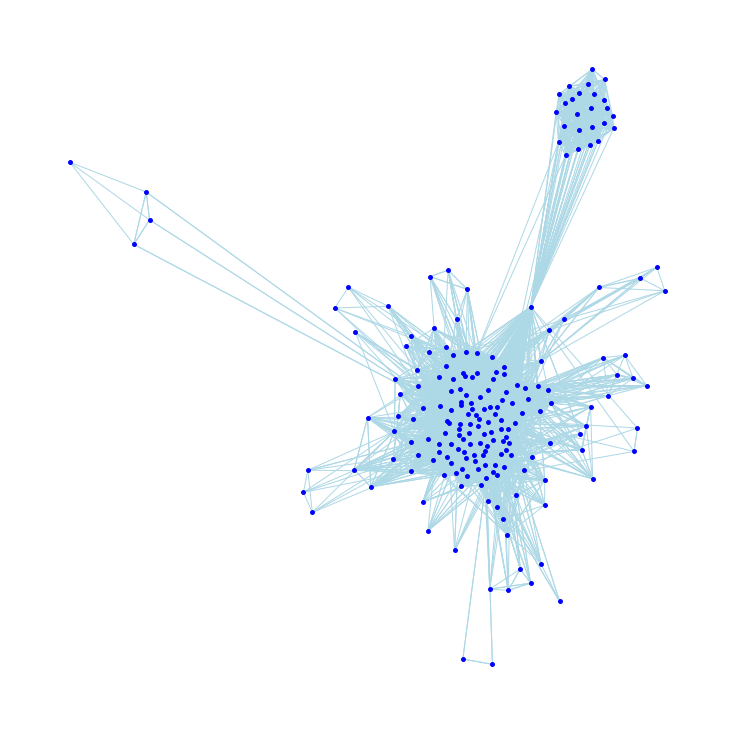

In [51]:
pos = nx.spring_layout(small_graph_f4)
plt.figure(figsize=(10,10))
nx.draw(small_graph_f4, pos,  node_size = 15, node_color='blue', edge_color='lightblue')
plt.show()

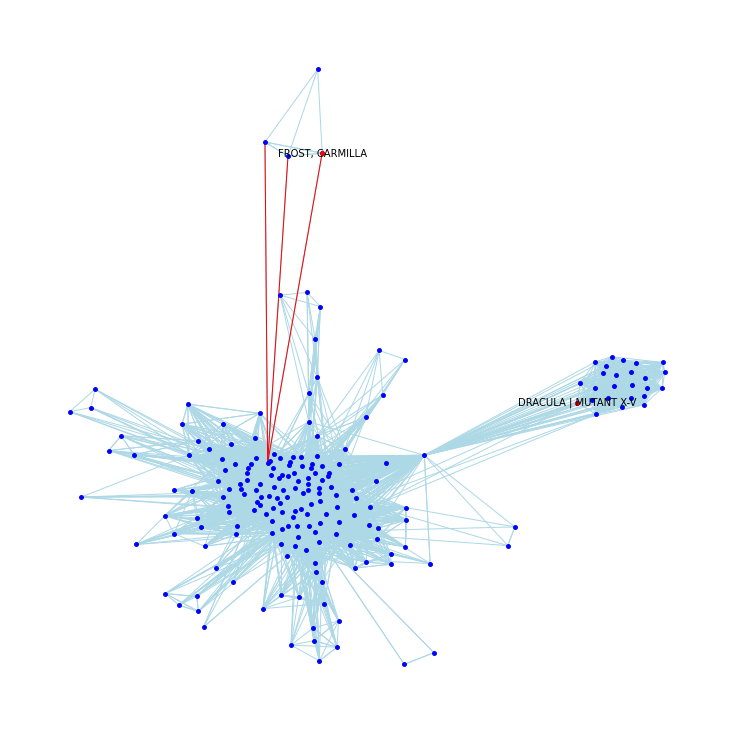

In [52]:
pos = nx.spring_layout(small_graph_f4)
labels = {'FROST, CARMILLA' : 'FROST, CARMILLA', 'DRACULA | MUTANT X-V' : 'DRACULA | MUTANT X-V'}
plt.figure(figsize=(10,10))
nx.draw(small_graph_f4, pos,  node_size = 15, node_color='blue', edge_color='lightblue')
nx.draw_networkx_edges(small_graph_f4, pos, vals, edge_color='red')
nx.draw_networkx_labels(small_graph_f4, pos, labels, font_size= 10)
nx.draw_networkx_nodes(small_graph_f4, pos,labels,  node_size = 15, node_color='red')
plt.show()

The aforementioned nodes are identified in the graph through their labels and the red-colored nodes.

In red we can see the 3 edges to be removed in order to disconnect the graph, obtaining therefore two sub-graphs identified by the two chosen superheroes.

## ***Functionality 5 - Extracting Communities***

In [55]:
def functionality_5 (graph_data, n, hero_1, hero_2, n_communities):
    
    small_graph = G_hero_net.subgraph(list(G_hero_net.nodes())[:n])
    comm, n_cut = myf.girvan_newman(small_graph.copy() , n_communities)    
    same = False
    for i in range(len(comm)):
        if (hero_1 in comm[i] and hero_2 in comm[i]):
            same = True
            
    if same == False:
        print("The two heroes are not in the same community")
    else:
        print("The two heroes are in the same community")
    
    return comm, n_cut
    

In [56]:
comm, n_cut = functionality_5(G_hero_net, n = 200, hero_1 = 'CAPTAIN AMERICA', hero_2 = 'IRON MAN/TONY STARK', n_communities = 3)
print("The number of communities is: ", len(comm))
print("The communities are: ", comm)

The two heroes are in the same community
The number of communities is:  3
The communities are:  [{'MCMURRAY, YVONNE', 'BALDER [ASGARDIAN]', 'CALLISTO', "BLACK PANTHER/T'CHAL", 'FALCON/SAM WILSON', 'ANGEL/WARREN KENNETH', 'GATEWAY', 'HOGUN [ASGARDIAN]', 'EENY', 'SCARLET WITCH/WANDA', 'HECTOR II', 'MOONDRAGON/HEATHER D', 'CYCLOPS/SCOTT SUMMER', 'CAGE, LUKE/CARL LUCA', 'TORPEDO III/BROCK JO', 'BANNER, BETTY ROSS T', 'MARITA', 'BOOMER/TABITHA SMITH', 'HAWK', "RA'AL", 'TRAVELER', "A'YIN", 'PHARAOH RAMA-TUT', 'CAPTAIN MARVEL/CAPTA', 'IRON MAN/TONY STARK', 'DR. DRUID/ANTHONY LU', 'STILT-MAN/WILBUR DAY', 'LEADER/SAM STERNS', 'SHADOWCAT/KATHERINE', 'CAPTAIN AMERICA', 'DEANGELO, DEVLIN', 'HEIMDALL [ASGARDIAN]', 'THUNDERBIRD II/JAMES', 'SHERIDAN, RICHARD RI', 'THOR/DR. DONALD BLAK', 'VOLSTAGG', 'MARVEL BOY III/ROBER', 'TSUNG, MARCUS', 'HAVOK/ALEX SUMMERS', 'SHROUD/MAXIMILLIAN Q', 'QUICKSILVER/PIETRO M', 'AURORA/JEANNE-MARIE', 'PROFESSOR X/CHARLES', 'MIKHLO', 'WOLFSBANE/RAHNE SINC', 'MAGGOTT/JAPHE

## ***Visualization 5 - Visualize the communities***

In [57]:
print("The minimum number of edges that should be removed to form communities is: ", n_cut)

The minimum number of edges that should be removed to form communities is:  47


In [59]:
myf.table_of_communities(comm)

,Heroes in each community
Community_1,"{MCMURRAY, YVONNE, BALDER [ASGARDIAN], CALLIST..."
Community_2,"{DRAX | MUTANT X-VERS, VOLSTAGG | MUTANT X-, A..."
Community_3,"{24-HOUR MAN/EMMANUEL, KILLRAVEN/JONATHAN R, M..."


This is the graph of the first 200 nodes of the network.
As we can see frome the visualization below, there are already some groups of nodes that lie out from the more dense and central principal group. 

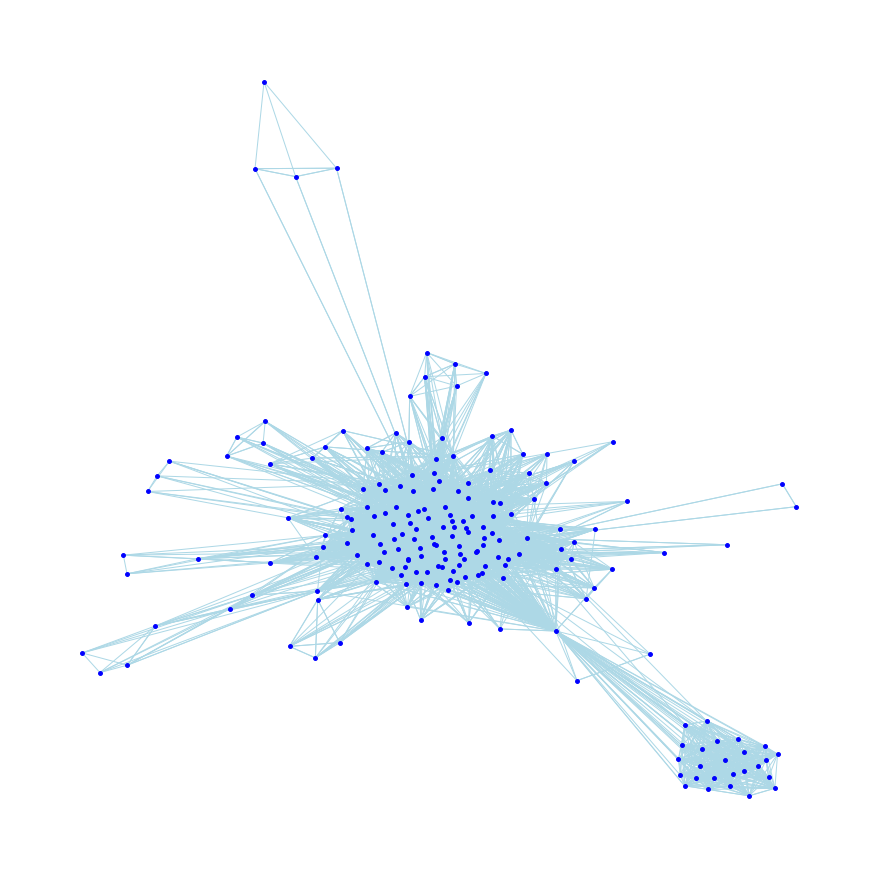

In [60]:
comm_full_graph = G_hero_net.subgraph(list(G_hero_net.nodes())[:200])
pos = nx.spring_layout(comm_full_graph)

plot_of_the_communties = nx.subgraph(comm_full_graph, comm[0])
fig = plt.figure(figsize=(12, 12))
nx.draw(comm_full_graph, pos, with_labels=False, node_size = 15, node_color='blue', edge_color='lightblue')

As we expected, the aforementioned outliyng groups of nodes coincide with the identified communities. In fact in the plot below we can see:
* ***Community 1*** -> In **RED**:  the second group of nodes, composed of 25 nodes. 
*  ***Community 2*** -> In **BLUE**:  the macro group of nodes, composed of 171 nodes. 
* ***Community 3*** -> In **YELLOW**:  the smallest group of nodes, composed of only 4 nodes.

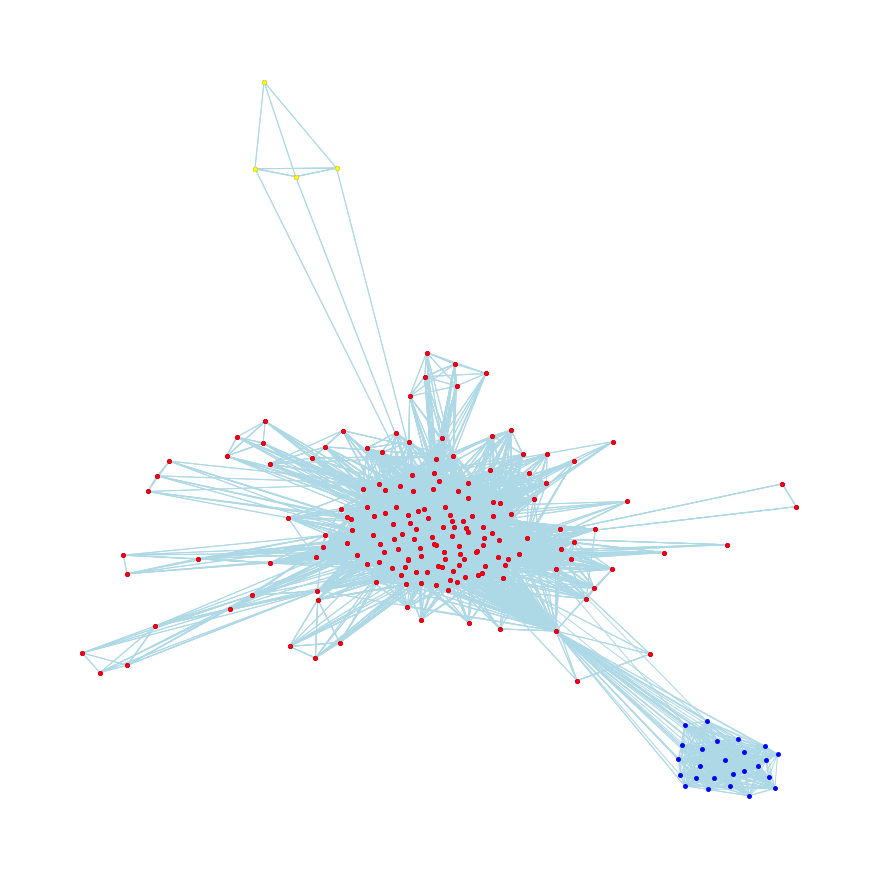

In [61]:
comm_full_graph = G_hero_net.subgraph(list(G_hero_net.nodes())[:200])

community_1 = nx.subgraph(comm_full_graph, comm[0])
community_3 = nx.subgraph(comm_full_graph, comm[2])
fig = plt.figure(figsize=(12, 12))
nx.draw(comm_full_graph, pos, with_labels=False, node_size = 15, node_color='blue', edge_color='lightblue')
nx.draw(community_1, pos, with_labels=False, node_size = 15, node_color='red', edge_color='lightblue')
nx.draw(community_3, pos, with_labels=False, node_size = 15, node_color='yellow', edge_color='lightblue')

In red we can see that 'CAPTAIN AMERICA' and 'IRON MAN/TONY STARK' are at the center of the macro-group in blue meaning that they belong to **community 2**.
This makes sense because they are two important heroes in the Marvel universe as they had a lot of collaborations with other superheroes in the various comics.

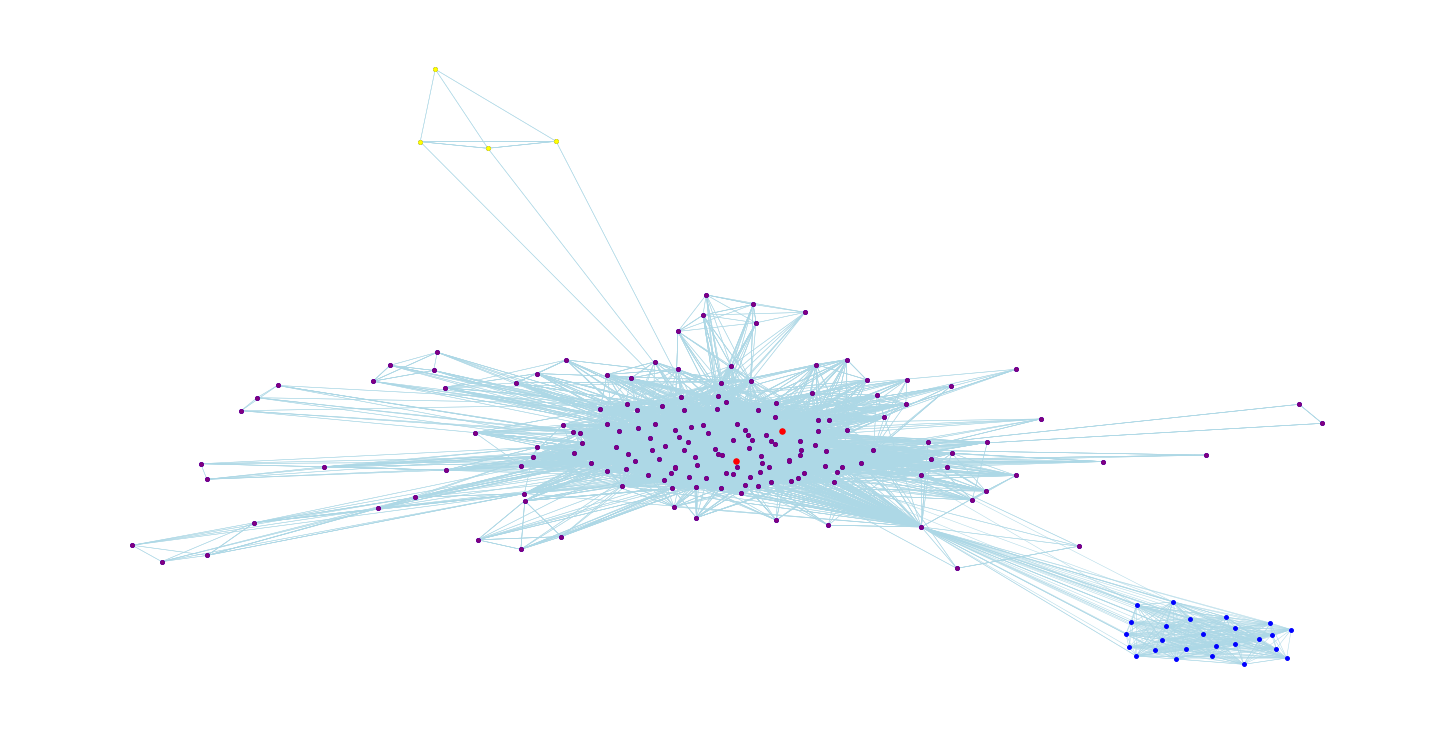

In [62]:
labels = {'CAPTAIN AMERICA': 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK': 'IRON MAN/TONY STARK'} 
plt.figure(figsize=(20,10))
nx.draw(comm_full_graph, pos, with_labels=False, node_size = 15, node_color='blue', edge_color='lightblue', width=0.5)
nx.draw(community_1, pos, with_labels=False, node_size = 15, node_color='purple', edge_color='lightblue', width=0.5)
nx.draw(community_3, pos, with_labels=False, node_size = 15, node_color='yellow', edge_color='lightblue', width=0.5)
nx.draw_networkx_nodes(comm_full_graph, pos, labels, node_color='red', node_size = 30)
plt.show()

## 6. Algorithmic Question

Alex and Sarah have been together for two years, and Alex is now thinking about proposing to her. But, to surprise her, he wants to install an app on her phone that asks her if she will marry him at the right time.

However, to install the application secretly, he needs her phone's password, which he does not have. He knows her password is a poly-line made up of vertical or horizontal line segments. In a 3*3 grid, each line segment connects the centres of two cells. Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment, but he is sure that her phone's operating system does not allow the poly-line to intersect with itself even at one point.

Alex wants to distract Sarah's attention long enough to test all possible patterns based on the directions of the line segments he has learned. Therefore, he needs you to assist him in calculating how many possible patterns he has to try based on those directions to estimate how much time he needs to check all of those possibilities. Given that the line segments were directed right, down, left, and up, the following figure depicts two valid and one invalid (as the poly-lines should not intersect even in one point) patterns.

In [64]:
def remove_doubles(word): #function to remove double character from a word
    result = ""
    previous_char = ""
    for char in word:
        if char != previous_char:
            result += char
        previous_char = char
    return result

In [65]:
def triplette(word): #function that return 1 if the word have three consecutive equal character and 0 otherwise
    Word=[i for i in word]
    for i in range(len(Word)-2):
        if (Word[i]==Word[i+1]):
            if Word[i+1]==Word[i+2]:
                return 1
    return 0
def path_or_not(Permutation,cnt,Start,tmp,repeat): #function that return 1 if exist a path for a specific sequence of directions
                                                   #(doubles included) and 0 if not
    
    #we want to access to a dict where the keys are the starting point of the grid and the values are the possible steps from it
    if Permutation[cnt]=='D': 
        Dict=D
    if Permutation[cnt]=='U':
        Dict=U
    if Permutation[cnt]=='R':
        Dict=R
    if Permutation[cnt]=='L':
        Dict=L
        
    if (Dict[Start][0]==0): #the value 0 in the dict means that there are no further steps from the Start
        return [0,repeat,tmp]
        
        
    if len(Dict[Start])==1: #splitting the code based on the length of the possible steps from the Start (NB: the maximum length is 2)
        if (Dict[Start][0] in tmp): #tmp is a list where we store all the visited point, so if the further step is already in tmp, this path is not allowed
            return [0,repeat,tmp]
        else:
            if cnt!=(len(Permutation)-1): #cnt is a counter that iterate the letters of the string
                tmp.append(Dict[Start][0]) #appending the visited node
                cnt=cnt+1 #increasing the counter to visit the next direction in the string list
                Start=Dict[Start][0] #the new start we'll have 
                return path_or_not(Permutation,cnt,Start,tmp,repeat) #calling recoursively the function with the new parameters
            else:
                tmp.append(Dict[Start][0]) #if we have already visited all the string, then the path is a good one
                return [1,repeat,tmp]
    if len(Dict[Start])==2: #in case we have two possible nodes to visit
        repeat=1 #that's to know that we have to repeat the search 
        if (Dict[Start][0] in tmp): #checking if the node has already been visited
            return [0,repeat,tmp]
        else:
            if cnt!=(len(Permutation)-1):
                tmp.append(Dict[Start][0])
                cnt=cnt+1
                Start_tmp=Dict[Start][0] #temporary start that allow us to do the next operation
                Dict[Start]=[Dict[Start][1]] #removing the first possibile path from the values of the Start "key"
                Start=Start_tmp #changing the start
                return path_or_not(Permutation,cnt,Start,tmp,repeat) #calling recoursively the function with the new parameters
            else:
                tmp.append(Dict[Start][0])
                Dict[Start]=[Dict[Start][1]]
                return [1,repeat,tmp]     

In [66]:
string='DRU' #the string we are considering 
if len(string)>10:
    print('This string is not valid, insert it again:')
    string=input()
if remove_doubles(string)!=string:
    print('This string is not valid, insert it again:')
    string=input()

In [67]:
#we want to create all the possible paths to check 
#we permute the string and then we remove the permutation that for sure does not respect the requirements

string_single_characters=[i for i in string]
string_double_characters=[str(i+i) for i in string]
letters=list(set(string_single_characters+string_double_characters)) #list of character to permute


k = len(string) #the minimum length of the permutation
string_permut=[] 
for r in range(k,len(letters)+1):      
    for word in permutations(letters, r): #visiting the permutations list to not consider the one that are for sure not allowed
        string_perm_tmp=''.join(word)
        if(remove_doubles(string_perm_tmp)==string):
            if (triplette(string_perm_tmp)==0):
                string_permut.append(string_perm_tmp)


In [68]:
#creating the dict where:  the name of the dict is the direction, the keys is the position in the grid, the values are the possible further steps
U={1: [0], 2: [0], 3: [0], 4: [1], 5: [2], 6: [3], 7: [4,1], 8: [5,2], 9: [6,3]}
D={1: [4, 7], 2: [5, 8], 3: [6, 9], 4: [7], 5: [8], 6: [9], 7: [0], 8: [0], 9: [0]}
R={1: [2, 3], 2: [3], 3: [0], 4: [5, 6], 5: [6], 6: [0], 7: [8, 9], 8: [9], 9: [0]}
L={1: [0], 2: [1], 3: [2,1], 4: [0], 5: [4], 6: [5,4], 7: [0], 8: [7], 9: [8,7]}

num_path_cnt=0 #counter of eligible paths
for per in string_permut: #visiting string_permut that have the strings of the possible paths from the starting string in input
    i=1
    Permutation=[el for el in per]
    while (i<=9): #this is to visit all the 3x3 grid
        result=path_or_not(Permutation,cnt=0,Start=i,tmp=[i],repeat=0) #calling the function to check if this series of direction is good or not
        num_path_cnt=num_path_cnt+result[0] #increasing the counter if the path is eligible and doing nothing otherwise 
        if result[1]==1: #if we had a "repeating" output we don't call back the dict
            i+=1
        else: #if the "repeating" output is zero, we have to call back the dict initialization since the dict could have been changed before
            U={1: [0], 2: [0], 3: [0], 4: [1], 5: [2], 6: [3], 7: [4,1], 8: [5,2], 9: [6,3]}
            D={1: [4, 7], 2: [5, 8], 3: [6, 9], 4: [7], 5: [8], 6: [9], 7: [0], 8: [0], 9: [0]}
            R={1: [2, 3], 2: [3], 3: [0], 4: [5, 6], 5: [6], 6: [0], 7: [8, 9], 8: [9], 9: [0]}
            L={1: [0], 2: [1], 3: [2,1], 4: [0], 5: [4], 6: [5,4], 7: [0], 8: [7], 9: [8,7]}
            i+=1
print('The number of possible paths is:',num_path_cnt)

The number of possible paths is: 15
